In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
import allantools

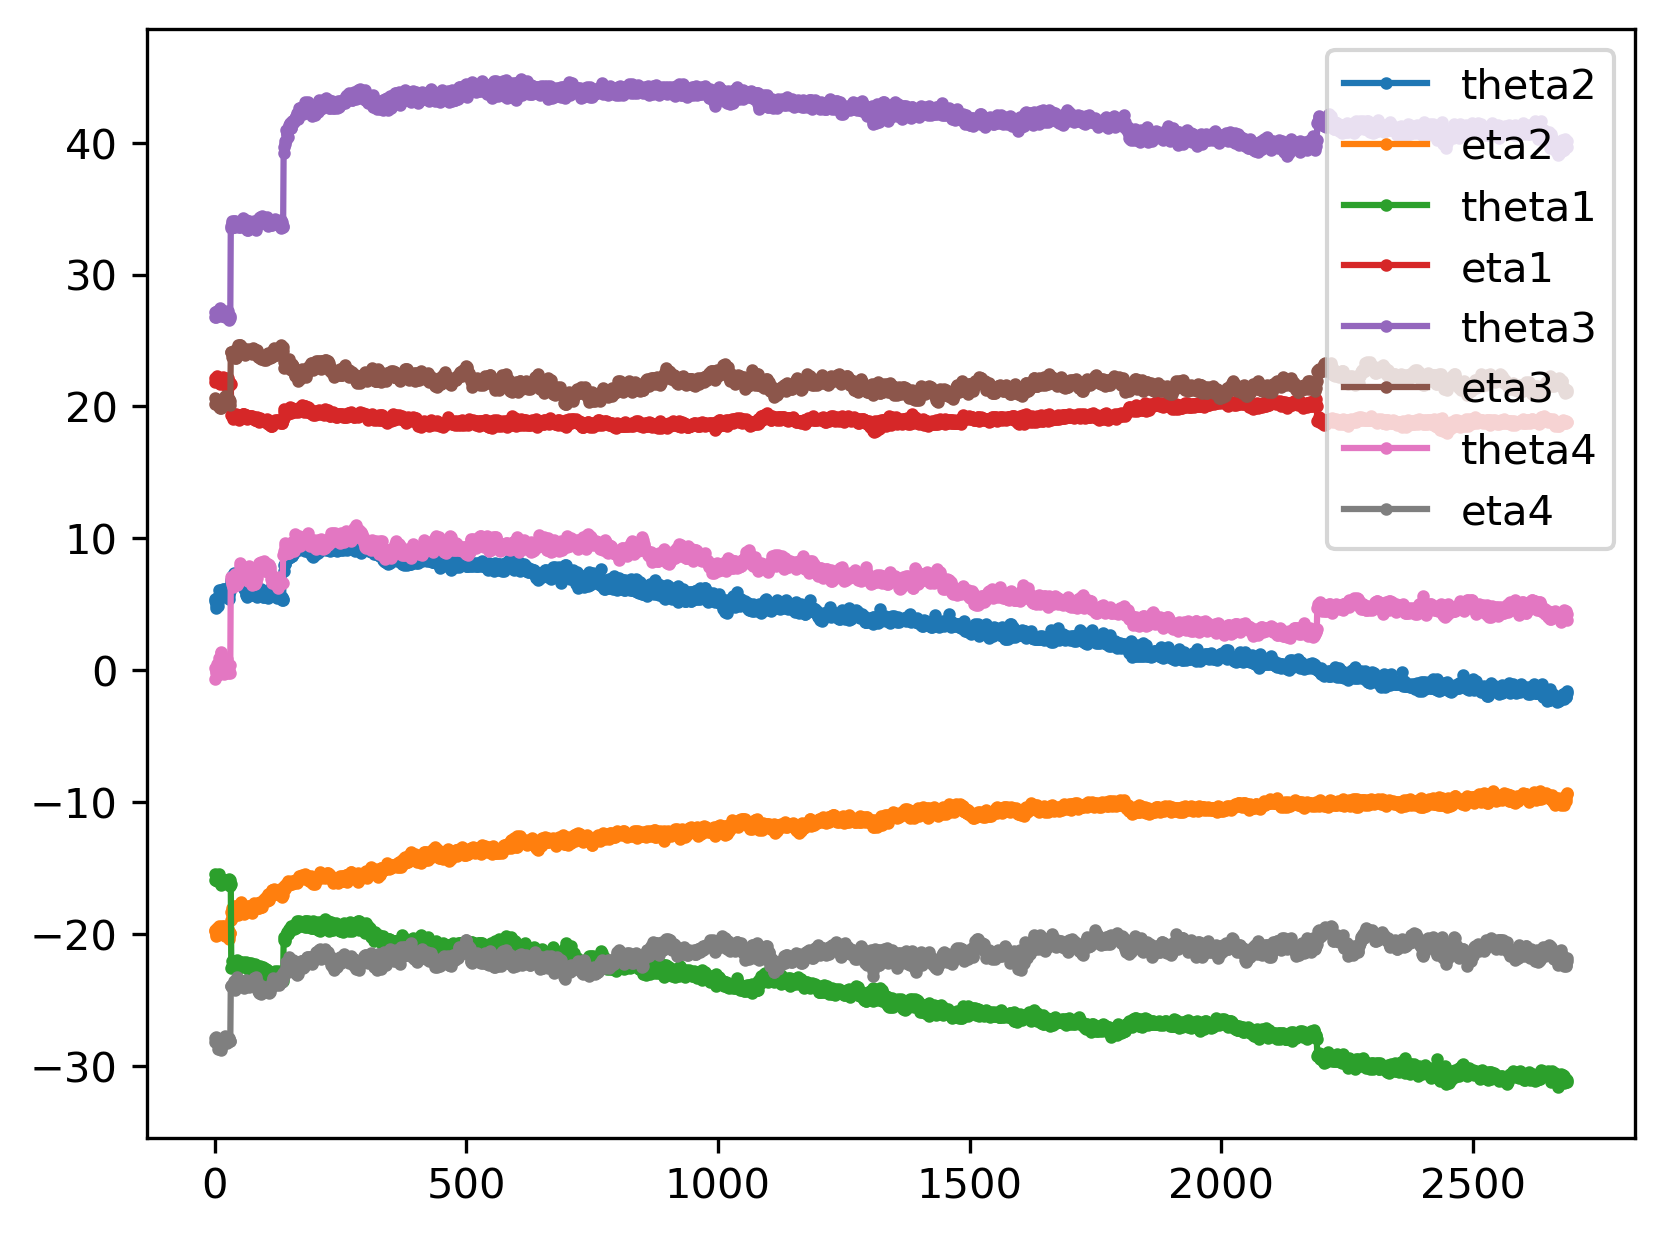

In [3]:
data = np.array(np.genfromtxt("4ChTestSlowSwitchingARL.csv", dtype = float, delimiter = ","))
ch1 = data[:,0]
ch2 = data[:,1]
ch3 = data[:,2]
ch4 = data[:,3]
dt1 = data[:,4]
theta1 = data[:,5]
eta1 = data[:,6]
dt2 = data[:,7]
theta2 = data[:,8]
eta2 = data[:,9]
dt3 = data[:,10]
theta3 = data[:,11]
eta3 = data[:,12]
dt4 = data[:,13]
theta4 = data[:,14]
eta4 = data[:,15]
plt.figure(dpi=300)
plt.plot(theta2*180/np.pi,"-o",ms = 2,label = "theta2")
plt.plot(eta2*180/np.pi, "-o",ms=2,label = "eta2")
plt.plot(theta1*180/np.pi, "-o", ms=2 ,label = "theta1")
plt.plot(eta1*180/np.pi, "-o", ms=2 ,label = "eta1")
plt.plot(theta3*180/np.pi,"-o",ms = 2,label = "theta3")
plt.plot(eta3*180/np.pi, "-o",ms=2,label = "eta3")
plt.plot(theta4*180/np.pi, "-o", ms=2 ,label = "theta4")
plt.plot(eta4*180/np.pi, "-o", ms=2 ,label = "eta4")
plt.legend()


In [4]:
## Angles to Stokes
def angToStokes(theta, eta):
    s1 = np.cos(2*theta)*np.cos(2*eta)
    s2 = np.sin(2*theta)*np.cos(2*eta)
    s3 = np.sin(2*eta)
    return np.array([s1,s2,s3])

## Grahm Schmidt and Cross Product
def getBasis(s1,s2):
    u1 = s1/np.linalg.norm(s1)
    res = np.dot(u1,s2)
    u2 = s2 - res*u1
    u2 = u2/np.linalg.norm(u2)
    u3 = np.cross(u1,u2)
    return np.array([u1,u2,u3])

## Matrix Solver
def getM(u1,u2,u3,v1,v2,v3):
    X = np.matrix([u1,u2,u3])
    V = np.array([v1,v2,v3])
    v1i = V[:,0]
    v2i = V[:,1]
    v3i = V[:,2]
    m1 = np.linalg.solve(X,v1i)
    m2 = np.linalg.solve(X,v2i)
    m3 = np.linalg.solve(X,v3i)
    M = np.matrix([m1,m2,m3])
    return M

In [5]:
MArr = []
for i in range(len(theta1)):
    th1 = theta1[i]
    et1 = eta1[i]
    s1 = angToStokes(th1,et1)
    th2 = theta2[i]
    et2 = eta2[i]
    s2 = angToStokes(th2,et2)
    u1,u2,u3 = getBasis(s1,s2)
    
    th3 = theta3[i]
    et3 = eta3[i]
    t1 = angToStokes(th3,et3)
    th4 = theta4[i]
    et4 = eta4[i]
    t2 = angToStokes(th4,et4)
    v1,v2,v3 = getBasis(t1,t2)
    
    M = getM(u1,u2,u3,v1,v2,v3)
    MArr.append(M)

In [38]:
eigArr = []
vArr = []
indexArr =[]
RotAngles =[]
for m in MArr:
    EigenM = np.linalg.eig(m)
    i = np.where( np.imag(EigenM[0]) ==0)[0][0]
    indexArr.append(i)
    vArr.append(EigenM[1][:,i])
    j=1
    if i == 1:
        j = 2
    phi = np.arccos(np.real(EigenM[0][j]))*180/np.pi
    RotAngles.append(phi)

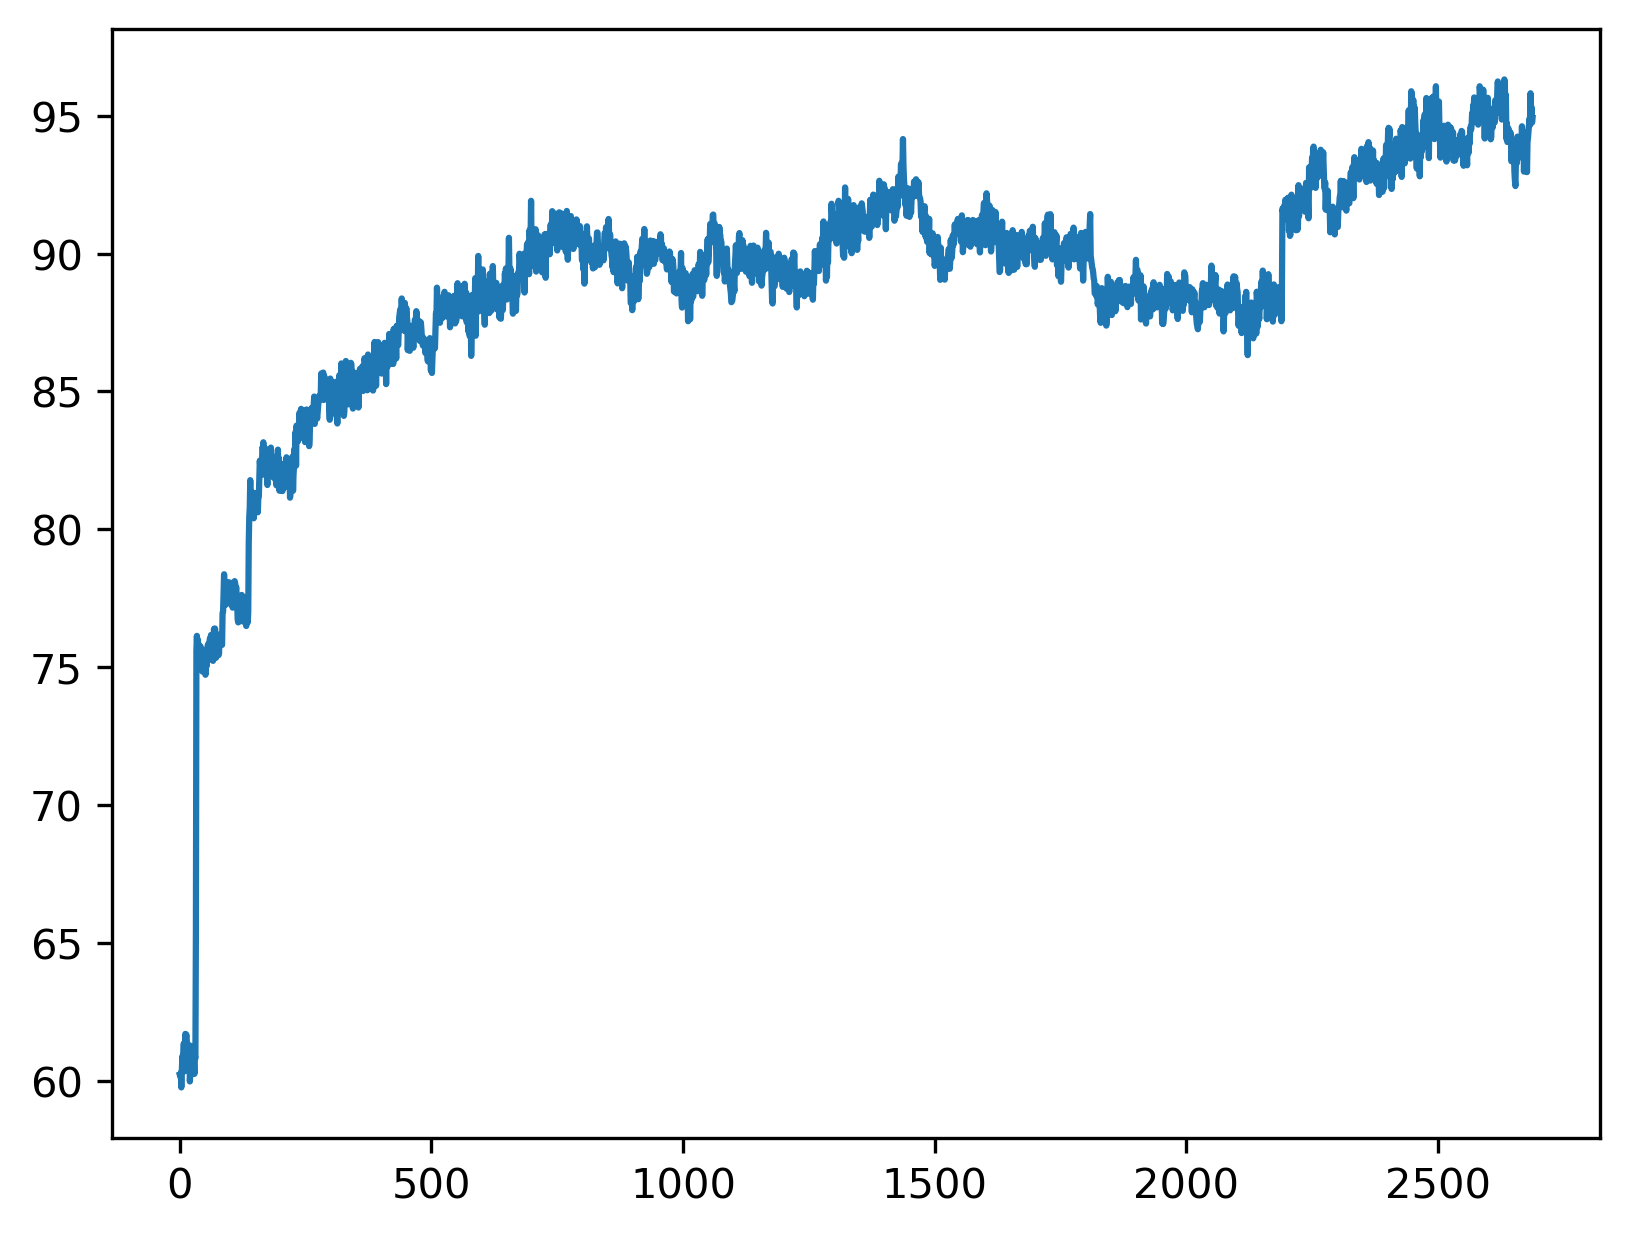

In [40]:
plt.figure(dpi=300)
plt.plot(RotAngles)

In [9]:
def stokesToEllipse(pState):
    S1 = pState[0,0]
    S2 = pState[1,0]
    S3 = pState[2,0]
    psi = 1/2*np.arctan(S2/S1)* 180/np.pi
    chi = 1/2*np.arctan(S3/(S1**2 + S2**2)**0.5) *180/np.pi
    return np.array([psi, chi])

In [10]:
t1 = time.time()
polarArr = []
for pState in vArr:
    polarArr.append(stokesToEllipse(pState))
print(time.time()-t1)
polarArr = np.array(polarArr)

0.044587135314941406


/Users/devenbowman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


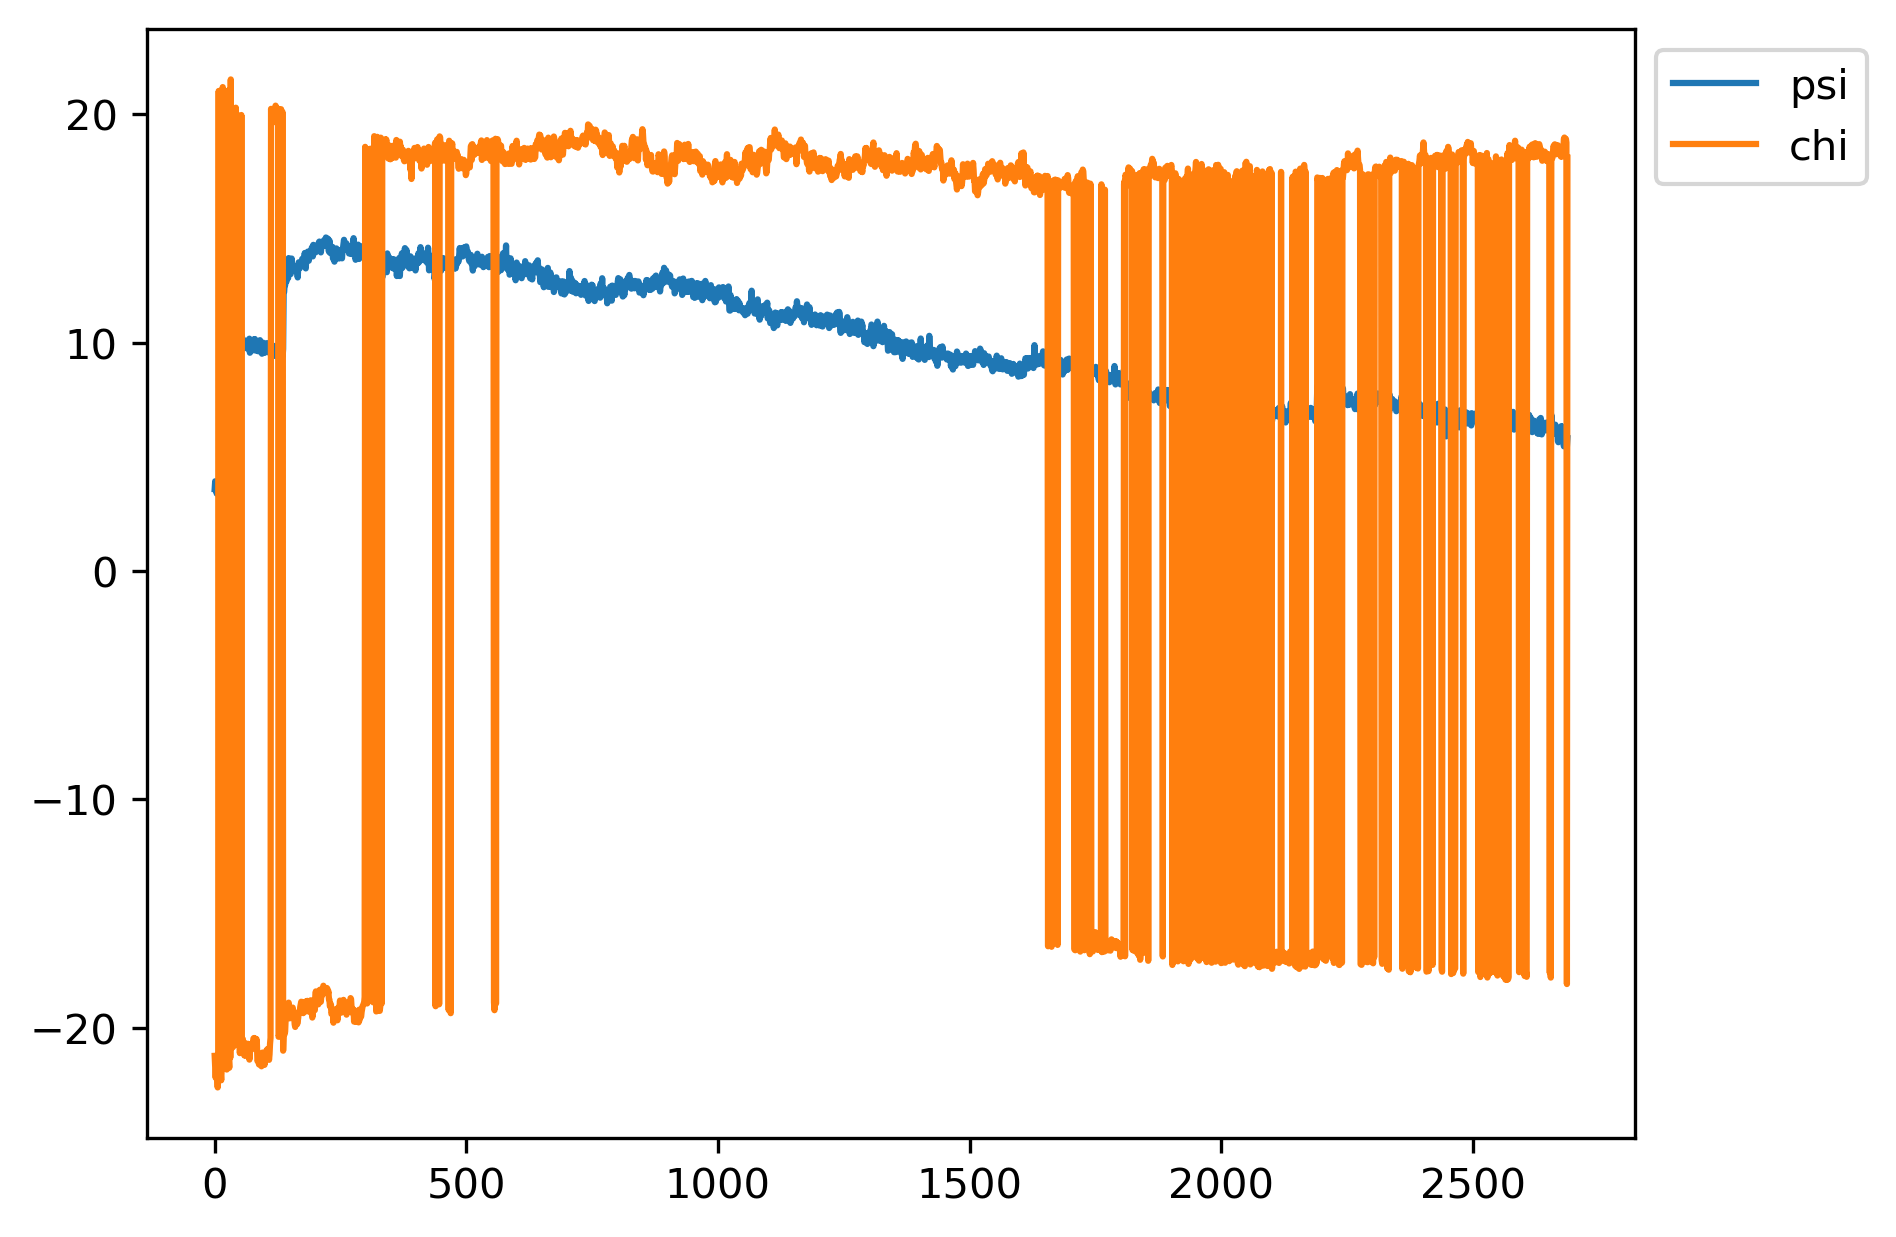

In [15]:
plt.figure(dpi=300)
plt.plot(polarArr[:,0], label = "psi")
plt.plot(polarArr[:,1], label = "chi" ) 
plt.legend(bbox_to_anchor = (1,1))

In [16]:
#there are sign errors seem to be artifacts of the analysis so they are corrected
correctedArr = np.abs(polarArr)

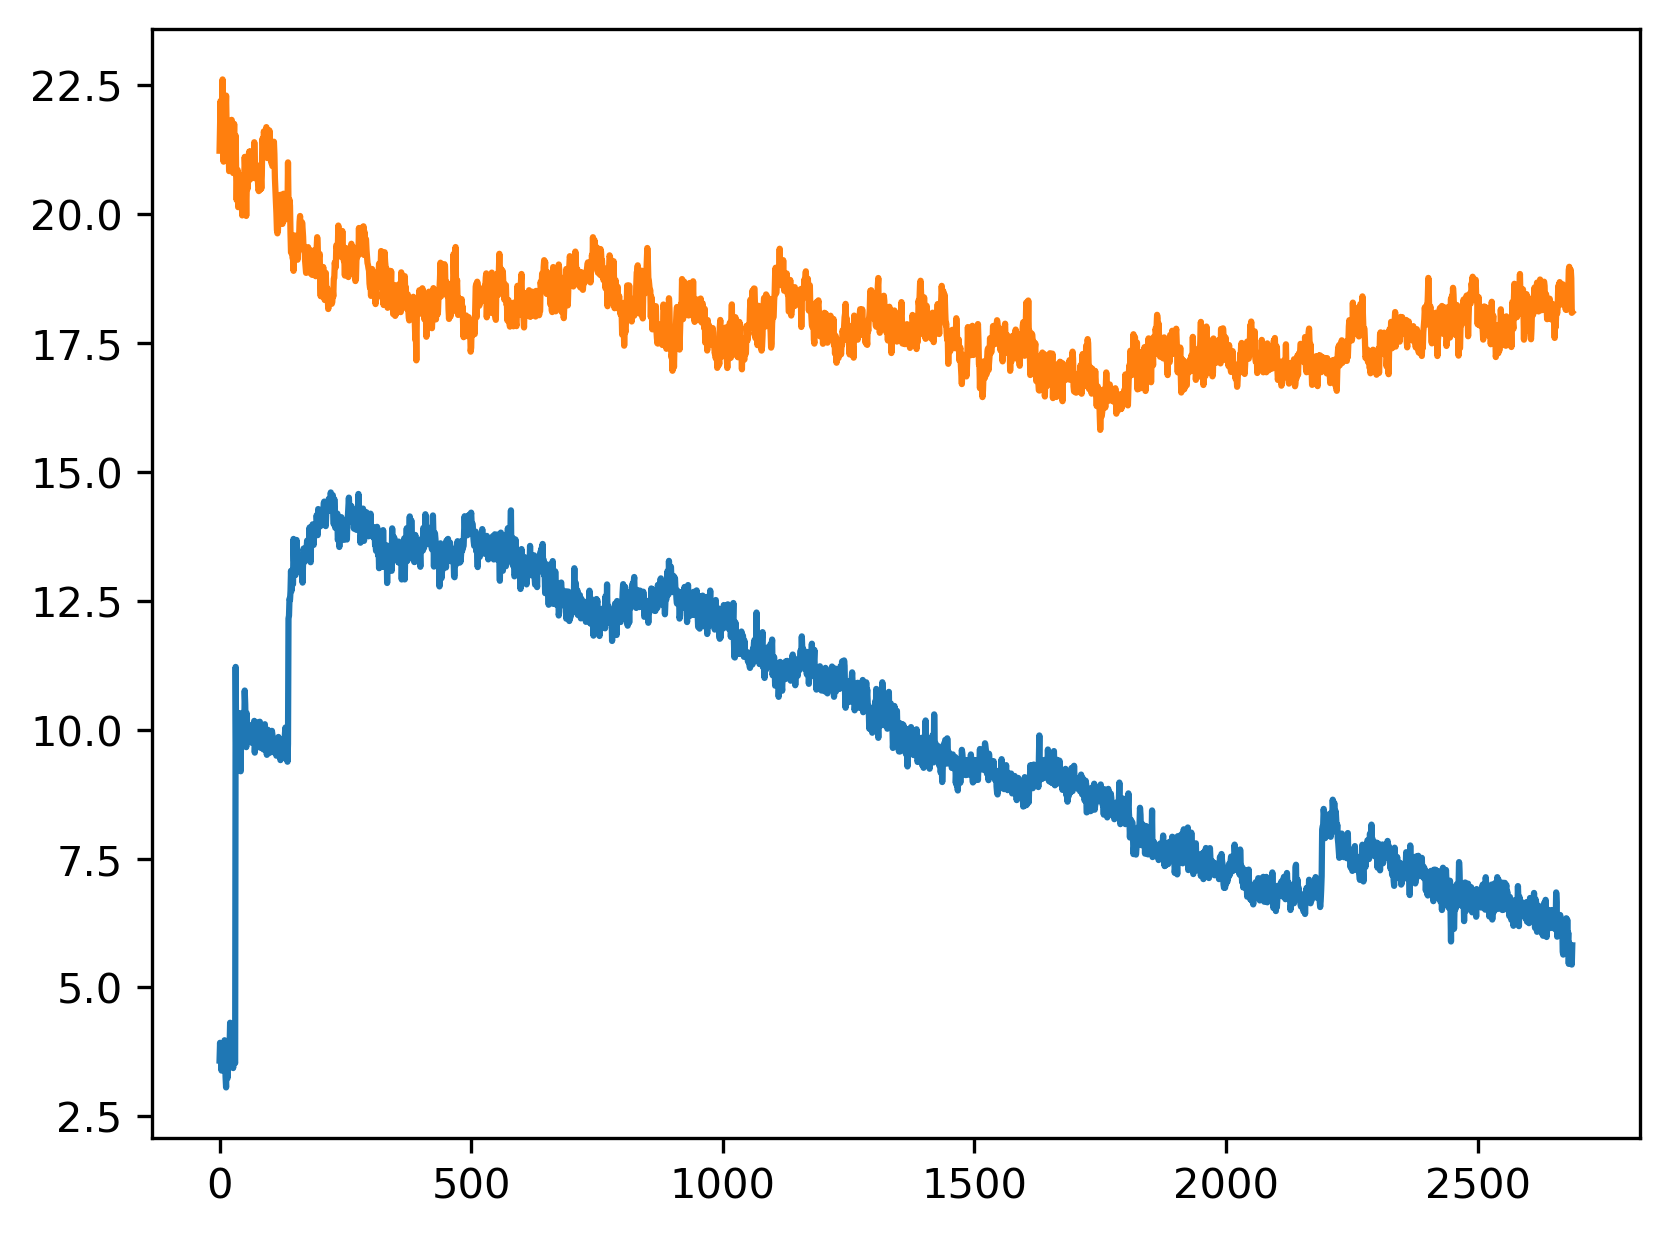

In [46]:
plt.figure(dpi=300)
plt.plot(correctedArr)

In [36]:
tau = 0.6 #s per measurement
stepArr = np.linspace(0,3.1,50)
stepArr = 10**stepArr
stepArr = [int(x) for x in stepArr]
stepArr = np.unique(stepArr)
tauArr = stepArr*tau

aDevAxis = [allantools.oadev(correctedArr[:,0], rate = tau**-1, taus=tauArr, data_type="freq"),
        allantools.adev(correctedArr[:,1], rate = tau**-1, taus=tauArr, data_type="freq")]

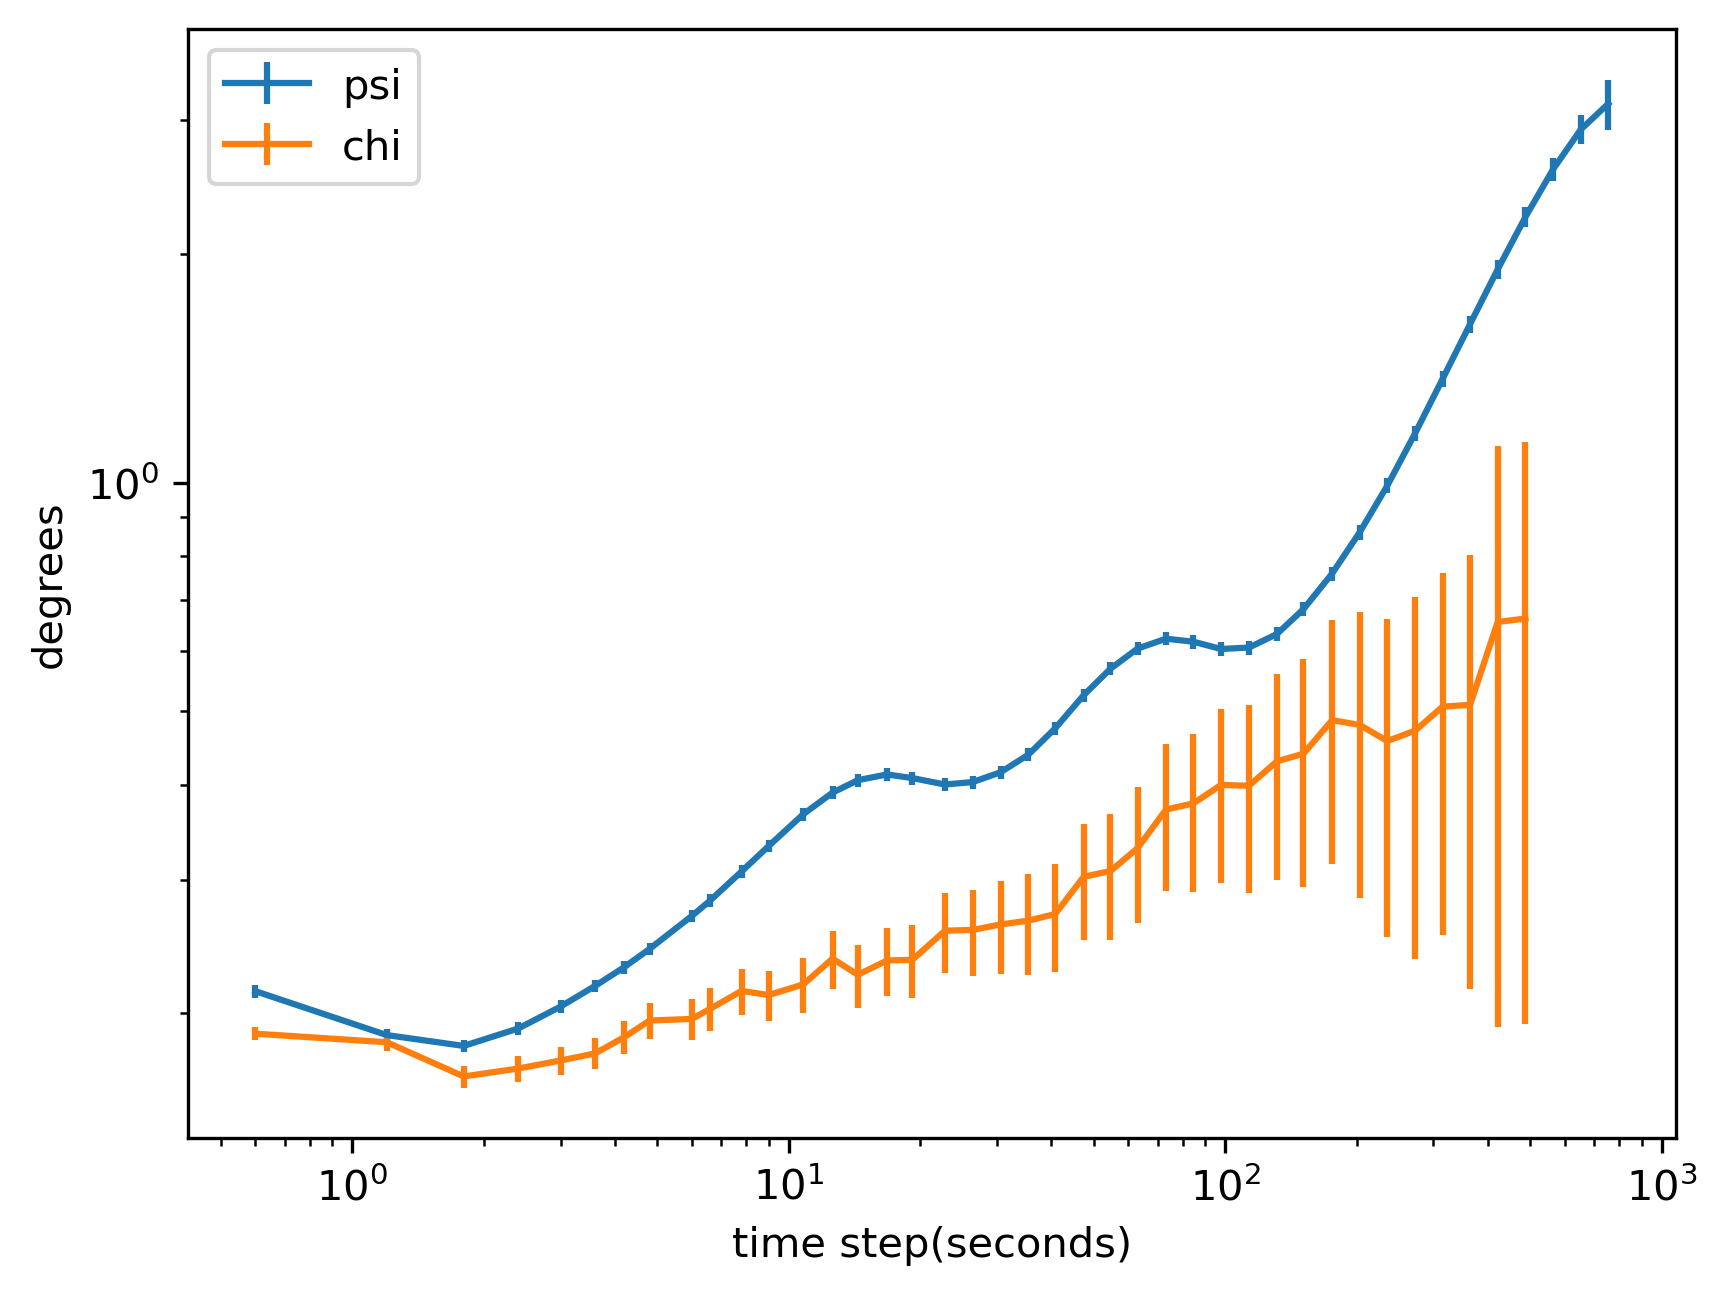

In [37]:
plt.figure(dpi=300)
plt.errorbar(aDevAxis[0][0],aDevAxis[0][1], yerr = aDevAxis[0][2], label = "psi")
plt.errorbar(aDevAxis[1][0],aDevAxis[1][1], yerr = aDevAxis[1][2], label = "chi")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("degrees")
plt.xlabel("time step(seconds)")
plt.legend()

In [41]:
aDevRotAng = allantools.oadev(RotAngles, rate = tau**-1, taus=tauArr, data_type="freq")

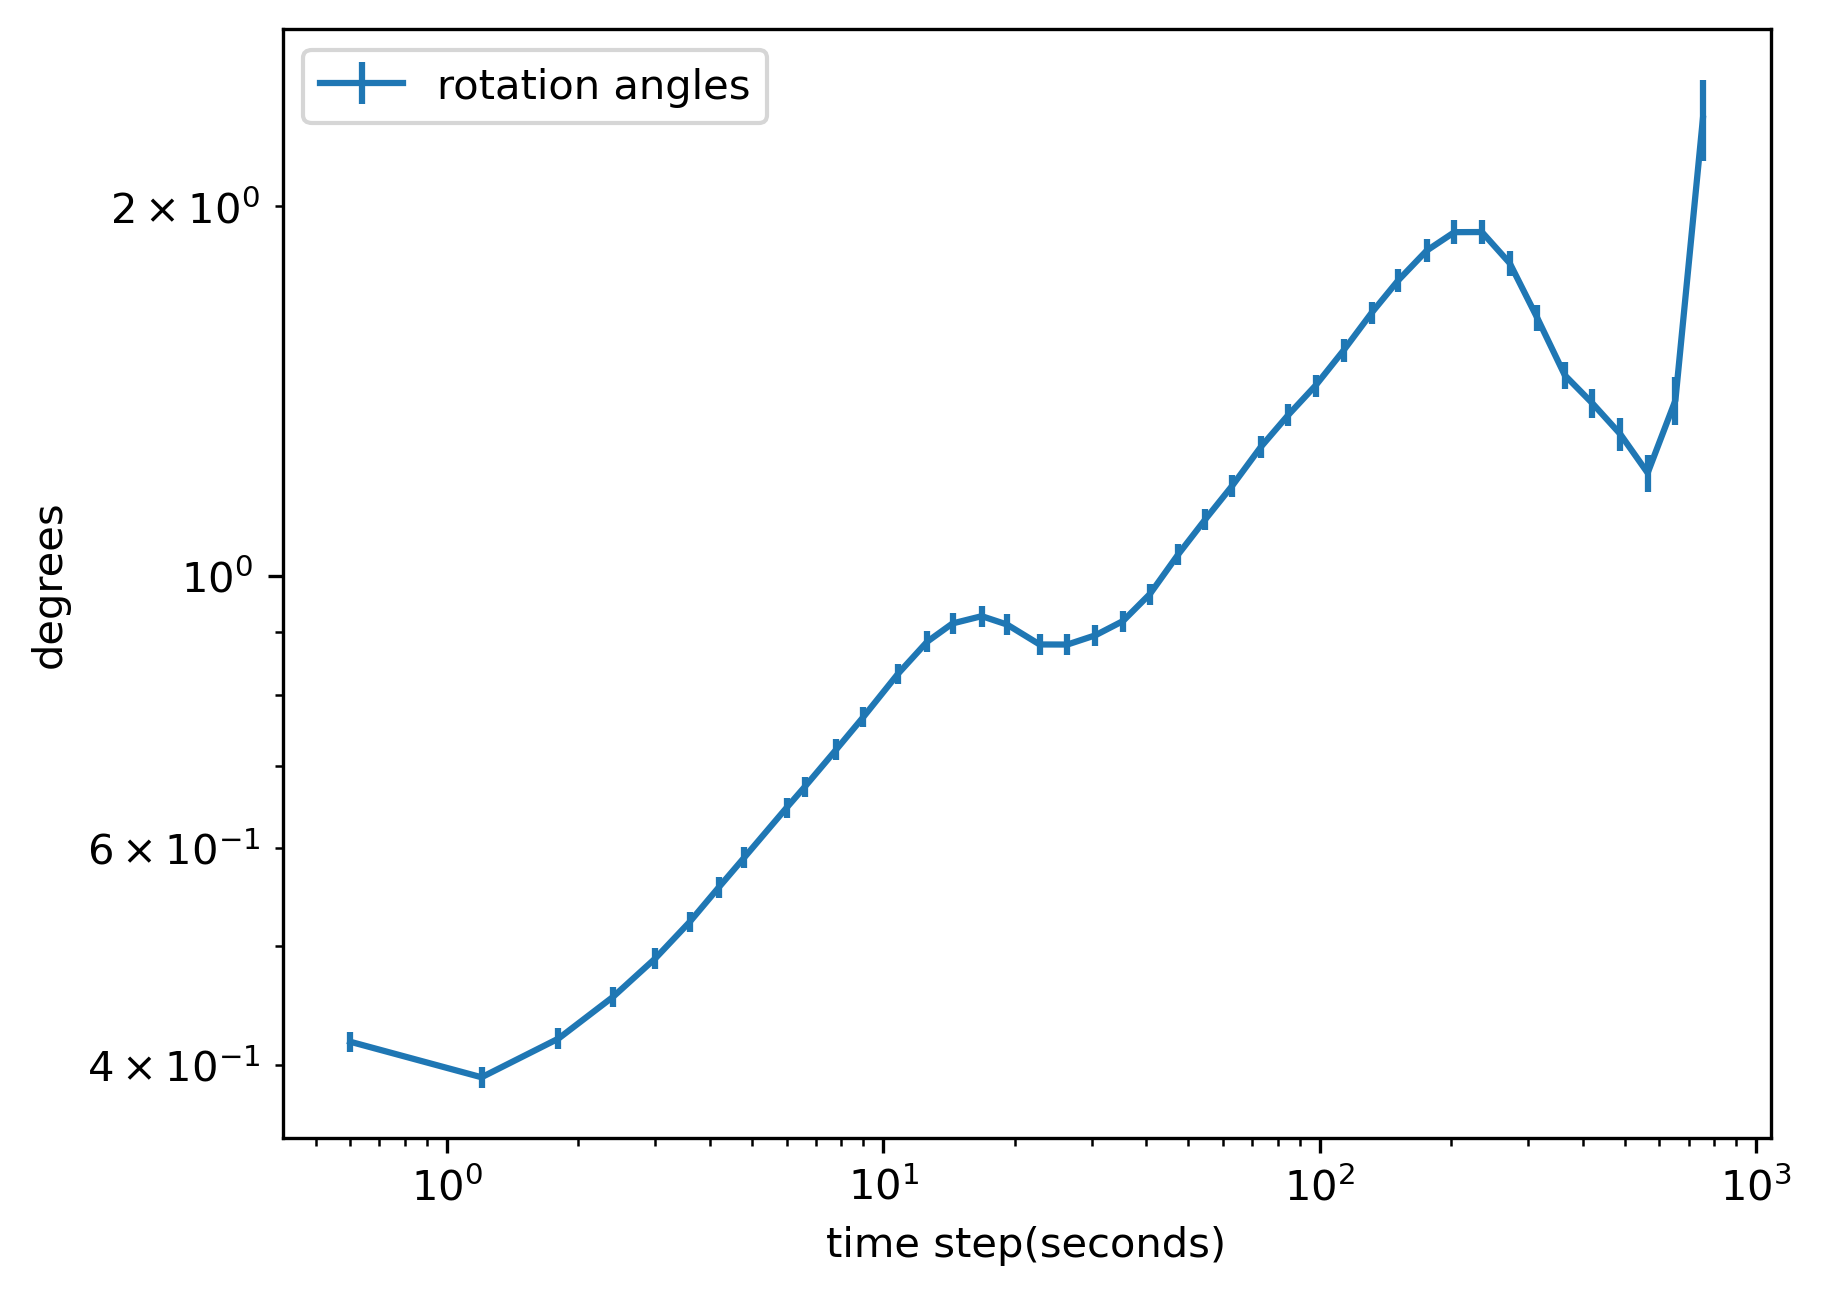

In [44]:
plt.figure(dpi=300)
plt.errorbar(aDevRotAng[0], aDevRotAng[1], yerr= aDevRotAng[2], label = "rotation angles" )
plt.xscale("log")
plt.yscale("log")
plt.ylabel("degrees")
plt.xlabel("time step(seconds)")
plt.legend()

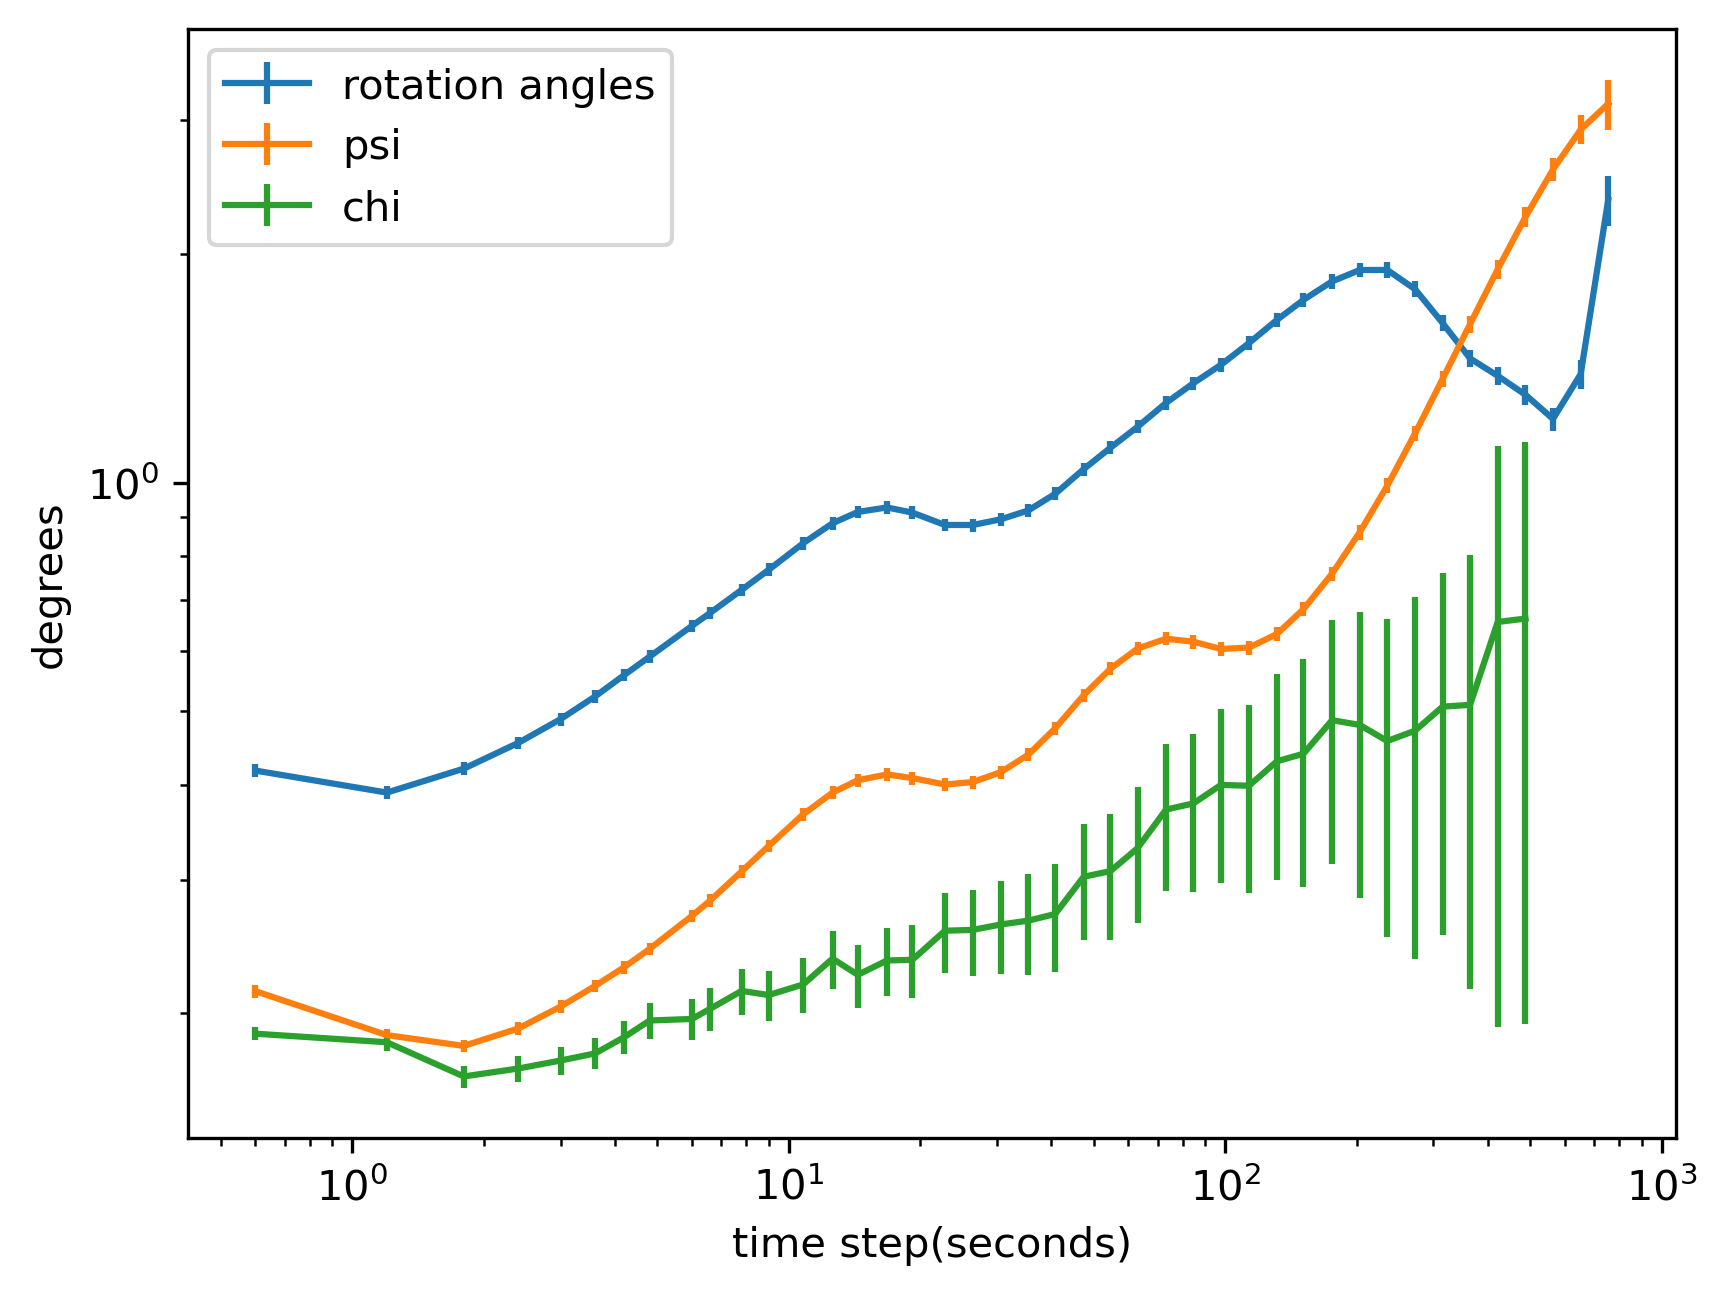

In [47]:
plt.figure(dpi=300)
plt.errorbar(aDevRotAng[0], aDevRotAng[1], yerr= aDevRotAng[2], label = "rotation angles" )
plt.errorbar(aDevAxis[0][0],aDevAxis[0][1], yerr = aDevAxis[0][2], label = "psi")
plt.errorbar(aDevAxis[1][0],aDevAxis[1][1], yerr = aDevAxis[1][2], label = "chi")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("degrees")
plt.xlabel("time step(seconds)")
plt.legend()